In [2]:
import json
import pandas as pd
today = "2018-12-27"

In [33]:
import json
def read_json(filename):
    with open(filename, "r") as f:
        return json.load(f)

today = "2018-12-27"

# list of arrays for each model.
cv_results = {alg: read_json(f"out/{today}/{today}-{alg}-cv_results.json") for alg in ["hyperband", "hyperband-w-patience", "patience"]}

# list of arrays with each score/time/etc. Each model entered more than once.
histories = {alg: read_json(f"out/{today}/{today}-{alg}-history.json")for alg in ["hyperband", "hyperband-w-patience", "patience"]}

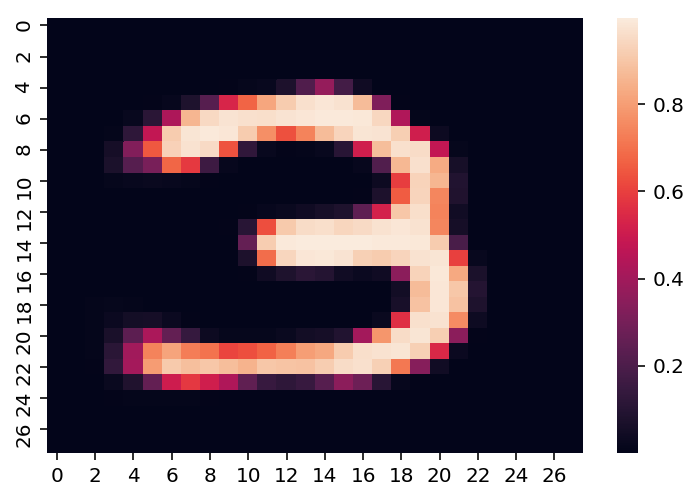

In [35]:
import numpy as np
data = np.load(f"out/{today}/{today}-hyperband-test.npz")
y_hat = data["y_hat"]

import seaborn as sns
sns.heatmap(y_hat[0].reshape(28, 28))

## Performance
`HyperbandCV` will find close to the best possible parameters with the given computational budget.*

<sup>* "will" := with high probability,
"close" := within log factors,
"best possible" in expected value.</sup>


In [42]:
def shape_history(history, **kwargs):
    """
    TODO: get list of times, smooth over that
    
    out = []
    for row in history:
        time = next(times)
        if time < row["time"]:
            out += [out[-1]]
        out += [process(row)]  
    """
    
    scores = {}
    pf_calls = {}
    
    out = []
    cumulative_pf_calls = 0
    
    start = history[0]["elapsed_wall_time"]
    for row in history:
        scores[row["estimator_id"]] = row["score"]
        pf_calls[row["estimator_id"]] = row["partial_fit_calls"]
        cumulative_pf_calls = sum(pf_calls.values())
        
        out += [{"best_score": max(scores.values()),
                 "elapsed_wall_time": row["elapsed_wall_time"] - start,
                 "cumulative_partial_fit_calls": sum(pf_calls.values()),
                 **kwargs}]
    return out

In [43]:
from copy import copy, deepcopy
def smooth_histories(hist_list):
    out = []
    data = {}
    hist_list = deepcopy(hist_list)
    times = sorted([h["elapsed_wall_time"] for hist in hist_list for h in hist])
    
    hists = {repeat: hist for repeat, hist in enumerate(hist_list)}
    for t in times:
        for k, hist in hists.items():
            h = deepcopy(hists[k][0])
            h.update({"elapsed_wall_time": t})
            out += [h]
            
            if hists[k][0]["elapsed_wall_time"] >= t and len(hists[k]) > 1:
                hists[k].pop(0)
    return out

In [45]:
medium_rare = [shape_history(hist, repeat=0, alg=k)
               for k, hist in histories.items()]
# medium = [smooth_histories(hist) for hist in medium_rare]

well_done = sum(medium_rare, [])

In [74]:
import pandas as pd
df = pd.DataFrame(well_done)
df.head(n=2)
df.elapsed_wall_time.describe()
print(df.alg.unique())
df.head()

['hyperband' 'hyperband-w-patience' 'patience']


,alg,best_score,cumulative_partial_fit_calls,elapsed_wall_time,repeat
0,hyperband,-0.168343,1,0.000000,0
1,hyperband,-0.168343,2,0.000003,0
2,hyperband,-0.168343,3,0.000017,0
3,hyperband,-0.160083,4,0.000018,0
4,hyperband,-0.160083,5,0.000020,0


Text(0.5,0,'Cumulative partial fit calls')

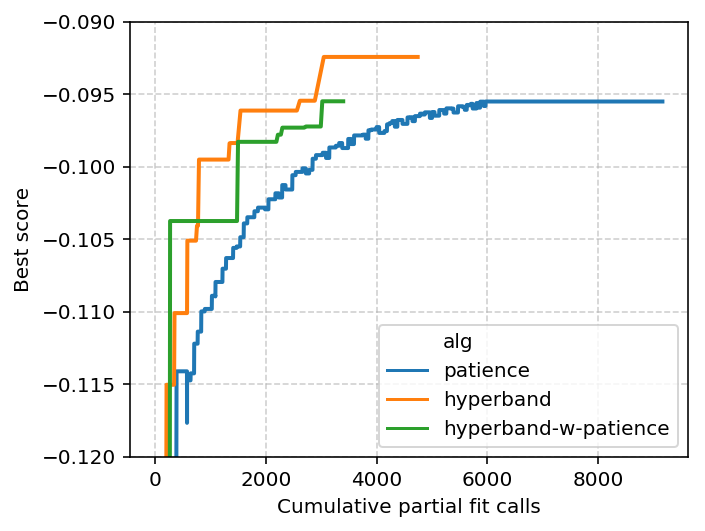

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.use()

adaptiveness = ["patience", "hyperband-w-patience", "hyperband"]
adaptiveness = ["patience", "hyperband", "hyperband-w-patience"]

show = df.copy()
# show["Passes through data"] = df["cumulative_partial_fit_calls"] / 3
fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.lineplot(
    data=show,
    x="cumulative_partial_fit_calls",
    y="best_score",
    hue="alg",
    hue_order=adaptiveness,
#     palette="magma_r",
    linewidth=2,
    ax=ax,
)
ax.set_ylim(-0.12, -0.09)
ax.grid(linestyle="--", alpha=0.6)
ax.set_ylabel("Best score")
ax.set_xlabel("Cumulative partial fit calls")

In [88]:
s = df[df.alg == "hyperband-w-patience"]

Text(0.5,0,'Elapsed time (min)')

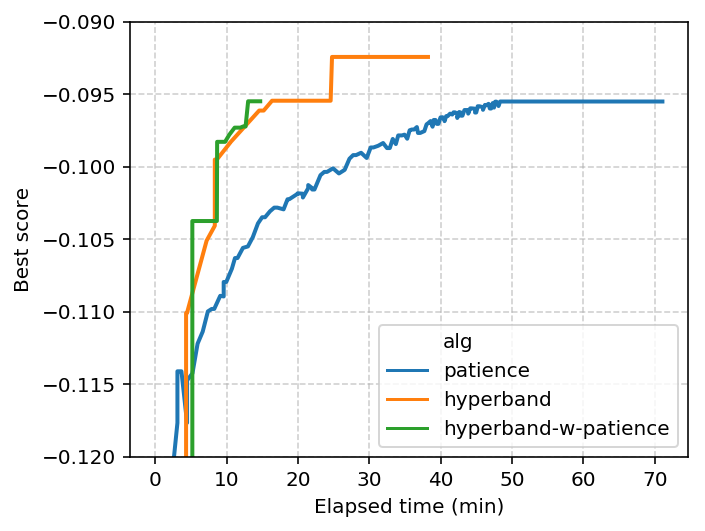

In [99]:
import seaborn as sns

adaptiveness = ["patience", "hyperband", "hyperband-w-patience"]

show = df.copy()
show["elapsed_wall_time (min)"] = show["elapsed_wall_time"] / 60

fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.lineplot(
    data=show,
    x="elapsed_wall_time (min)",
    y="best_score",
    hue="alg",
    hue_order=adaptiveness,
#     palette="magma_r",
    linewidth=2,
    ax=ax,
)
ax.set_ylim(-0.12, -0.09)
ax.grid(linestyle="--", alpha=0.6)
ax.set_ylabel("Best score")
ax.set_xlabel("Elapsed time (min)")

## Parameter visualization

In [101]:
# results = {k: [result[k] for result in cv_results["patience"]]
#               for k in cv_results["patience"][0]}
# results = {k: sum(v, []) for k, v in results.items()}

KeyError: 0

In [102]:
import numpy as np
hist = pd.DataFrame(cv_results["patience"])
hist.head()

#hist['param_optimizer_'] = hist['param_optimizer'].apply(lambda opt: str(opt).replace('<class', '').strip('>'))
hist['test_loss'] = -1 * hist['test_score']
hist = hist.sort_values(by='test_loss')
hist['rank'] = np.arange(len(hist)) + 1
hist.head()

,mean_partial_fit_time,mean_score_time,std_partial_fit_time,std_score_time,test_score,estimator_id,params,partial_fit_calls,param_train_split,param_optimizer__weight_decay,param_optimizer__nesterov,param_optimizer__momentum,param_optimizer__lr,param_optimizer,param_module__init,param_module__activation,param_batch_size,rank_test_score,test_loss,rank
21,10.062847,3.350648,6.167028,1.211837,-0.095504,21,"{'train_split': None, 'optimizer__weight_decay...",114,None,0.000015,True,0.445445,1.785467,SGD,kaiming_uniform_,ELU,32,1,0.095504,1
55,10.036392,3.574998,6.173667,1.392172,-0.096077,55,"{'train_split': None, 'optimizer__weight_decay...",103,None,0.000012,True,0.120120,2.437176,SGD,kaiming_normal_,ELU,32,2,0.096077,2
11,7.491892,3.113025,4.607077,0.938731,-0.097805,11,"{'train_split': None, 'optimizer__weight_decay...",144,None,0.000021,True,0.113113,1.656606,SGD,kaiming_normal_,PReLU,64,3,0.097805,3
14,7.147917,3.040090,4.481596,1.072677,-0.098660,14,"{'train_split': None, 'optimizer__weight_decay...",181,None,0.000011,True,0.491491,0.129752,SGD,xavier_uniform_,PReLU,64,4,0.098660,4
10,3.876608,2.563282,2.288659,0.713975,-0.098836,10,"{'train_split': None, 'optimizer__weight_decay...",111,None,0.000027,True,0.646647,3.288645,SGD,xavier_normal_,PReLU,512,5,0.098836,5


64 estimators


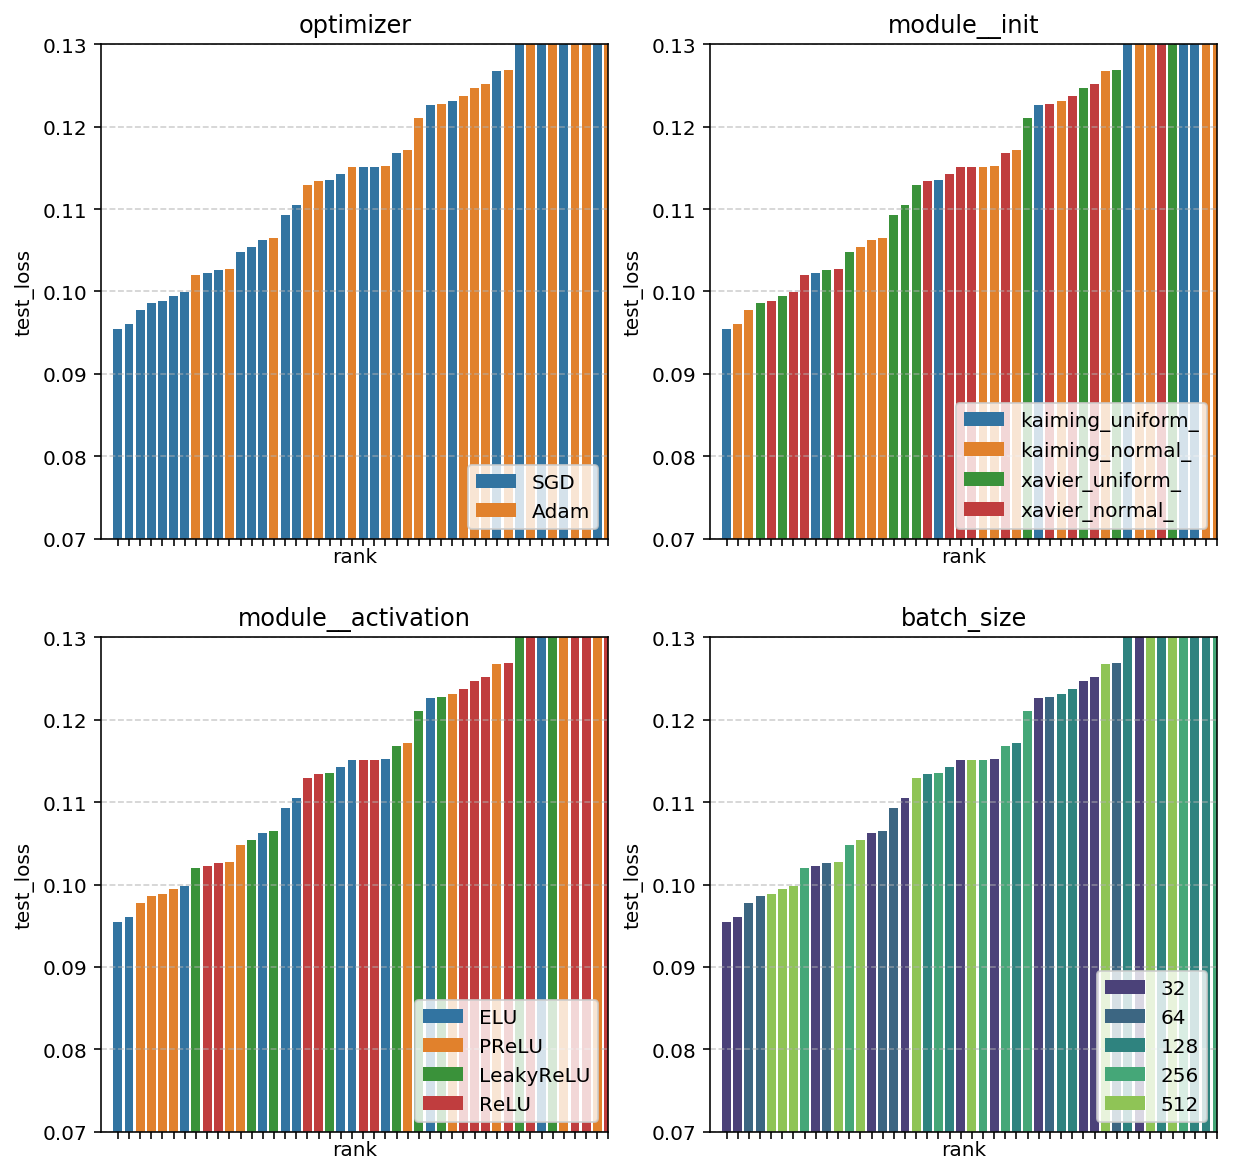

In [142]:
w = 5
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(2*w, 2*w))
axs = axs.flat[:]
hues = ['param_optimizer', 'param_module__init', 'param_module__activation', 'param_batch_size']
print("{} estimators".format(len(hist)))
for ax, hue in zip(axs, hues):
    cmap = None
    if 'batch_size' in hue:
        cmap = 'viridis'
    sns.barplot(
        x='rank', 
        y='test_loss',
        hue=hue,
        data=hist,
        ax=ax,
        palette=cmap,
        dodge=False,
    )
    ax.set_xlim(-1.5, 64 - 20)
    ax.set_ylim(0.07, 0.13)
    ax.grid(linestyle='--', axis='y', alpha=0.6)
    ax.legend(loc='lower right')
    ax.set_title(hue.replace('param_', ''))
    ax.tick_params(labelbottom=False)
plt.savefig("figs/ranks.svg", bbox_inches="tight")
plt.show()

In [139]:
sgd_alg = [a for a in hist.param_optimizer.unique() if 'sgd' in a.lower()][0]
sgd = hist[hist.param_optimizer == sgd_alg]
sgd.head()

,mean_partial_fit_time,mean_score_time,std_partial_fit_time,std_score_time,test_score,estimator_id,params,partial_fit_calls,param_train_split,param_optimizer__weight_decay,param_optimizer__nesterov,param_optimizer__momentum,param_optimizer__lr,param_optimizer,param_module__init,param_module__activation,param_batch_size,rank_test_score,test_loss,rank
21,10.062847,3.350648,6.167028,1.211837,-0.095504,21,"{'train_split': None, 'optimizer__weight_decay...",114,None,0.000015,True,0.445445,1.785467,SGD,kaiming_uniform_,ELU,32,1,0.095504,1
55,10.036392,3.574998,6.173667,1.392172,-0.096077,55,"{'train_split': None, 'optimizer__weight_decay...",103,None,0.000012,True,0.120120,2.437176,SGD,kaiming_normal_,ELU,32,2,0.096077,2
11,7.491892,3.113025,4.607077,0.938731,-0.097805,11,"{'train_split': None, 'optimizer__weight_decay...",144,None,0.000021,True,0.113113,1.656606,SGD,kaiming_normal_,PReLU,64,3,0.097805,3
14,7.147917,3.040090,4.481596,1.072677,-0.098660,14,"{'train_split': None, 'optimizer__weight_decay...",181,None,0.000011,True,0.491491,0.129752,SGD,xavier_uniform_,PReLU,64,4,0.098660,4
10,3.876608,2.563282,2.288659,0.713975,-0.098836,10,"{'train_split': None, 'optimizer__weight_decay...",111,None,0.000027,True,0.646647,3.288645,SGD,xavier_normal_,PReLU,512,5,0.098836,5


['SGD']


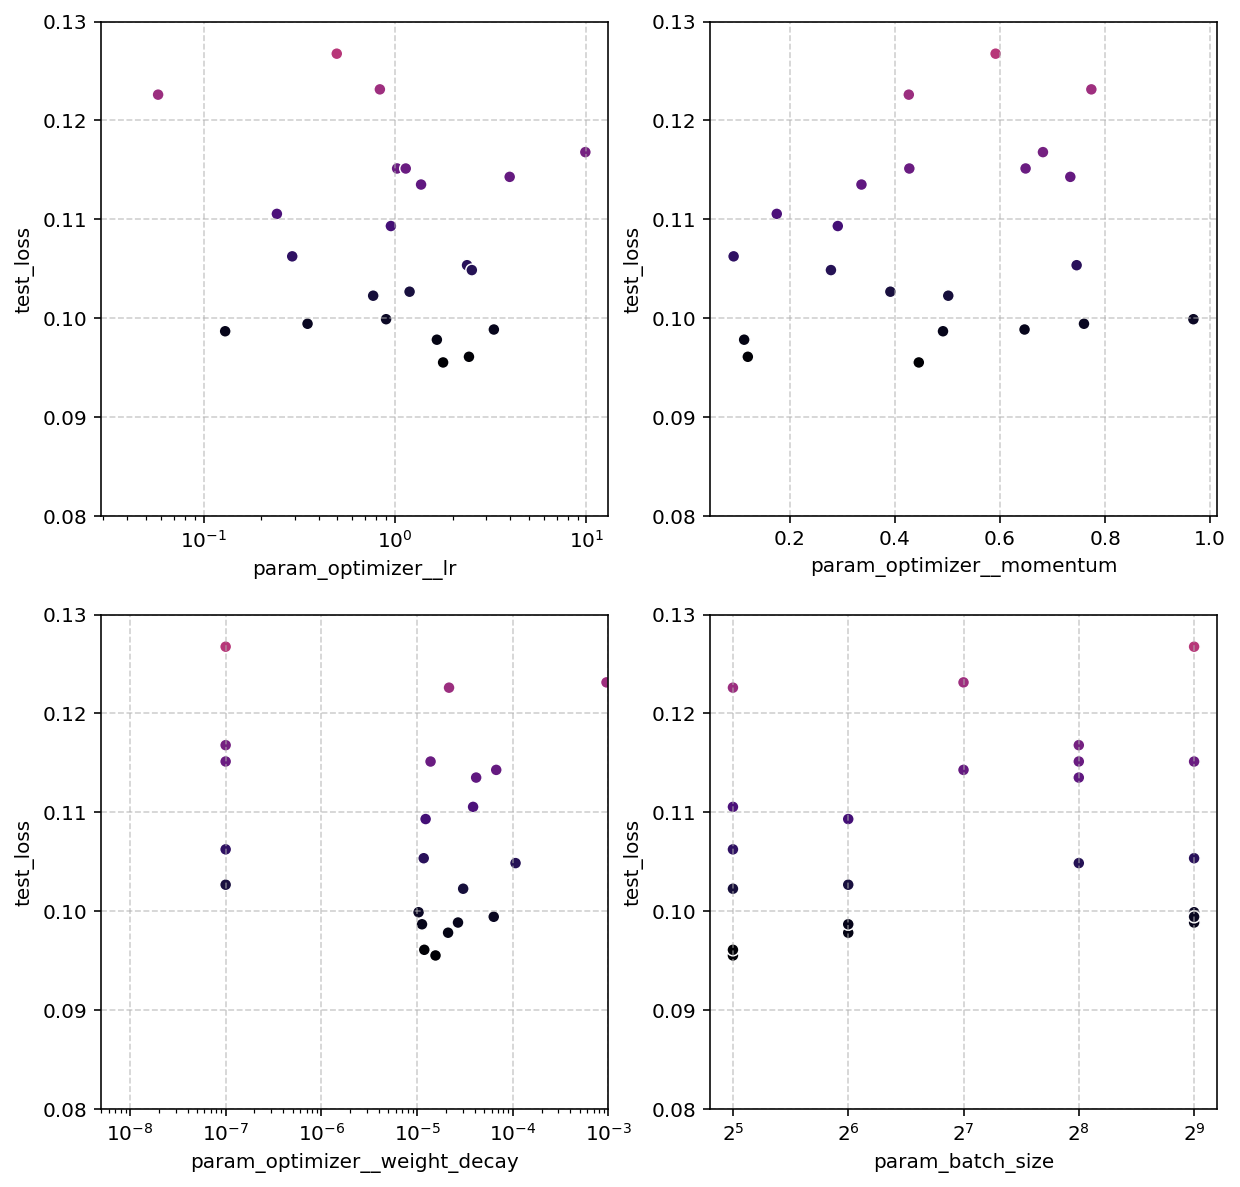

In [143]:
w = 5
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(2*w, 2*w))
axs = axs.flat[:]
variables = ['param_optimizer__lr', 'param_optimizer__momentum', 'param_optimizer__weight_decay', 'param_batch_size']
print(sgd.param_optimizer.unique())
for ax, var in zip(axs, variables):
    show = sgd.copy()
    show = show.sort_values(by=var)
    if 'weight_decay' in var:
        show[var] += 1e-7
    show = show[show.test_loss < 0.16]
    sns.scatterplot(
        x=var,
        y='test_loss',
        data=show,
        hue='test_loss',
        palette='magma',
        legend=False,
        ax=ax,
    )
    if 'lr' in var:
        ax.set_xscale('log', basex=10)
    if 'batch_size' in var:
        ax.set_xscale('log', basex=2)
    if 'weight_decay' in var:
        ax.set_xlim(5e-9, 1e-3)
        ax.set_xscale('log', basex=10)
    
    ax.grid(linestyle='--', alpha=0.6)
    ax.set_ylim(0.08, 0.13)
plt.savefig("figs/sgd.svg", bbox_inches="tight")
plt.show()